## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from sklearn.utils import class_weight
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
108710,00029487_001.png,No Finding,1,29487,40,M,PA,2021,2020,0.194311,0.194311,NaN,/data/images_012/images/00029487_001.png
68459,00016909_000.png,No Finding,0,16909,50,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_008/images/00016909_000.png
105709,00028451_000.png,No Finding,0,28451,61,M,PA,2544,3056,0.139000,0.139000,NaN,/data/images_012/images/00028451_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
96156,00025297_001.png,No Finding,1,25297,40,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50490,00012802_000.png,No Finding,0,12802,41,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32321,00008465_004.png,Pneumothorax,4,8465,28,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda label: "withPneumonia" if label else "withoutPneumonia")
all_xray_df['img_path'] = all_xray_df['Image Index'].map(lambda idx: all_image_paths[idx])
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,img_path
87093,00021492_000.png,Atelectasis,0,21492,39,M,PA,2504,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,withoutPneumonia,/data/images_010/images/00021492_000.png
16824,00004521_000.png,Atelectasis|Nodule,0,4521,68,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,withoutPneumonia,/data/images_003/images/00004521_000.png
100059,00026515_007.png,Edema,7,26515,66,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,withoutPneumonia,/data/images_011/images/00026515_007.png


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, valid_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['Pneumonia'])
    ## making equal proportions of Pneumonia in both sets!
    # traing data
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    # validation data
    p_inds = valid_data[valid_data.Pneumonia==1].index.tolist()
    np_inds = valid_data[valid_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    valid_data = valid_data.loc[p_inds + np_sample]
    return train_data, valid_data



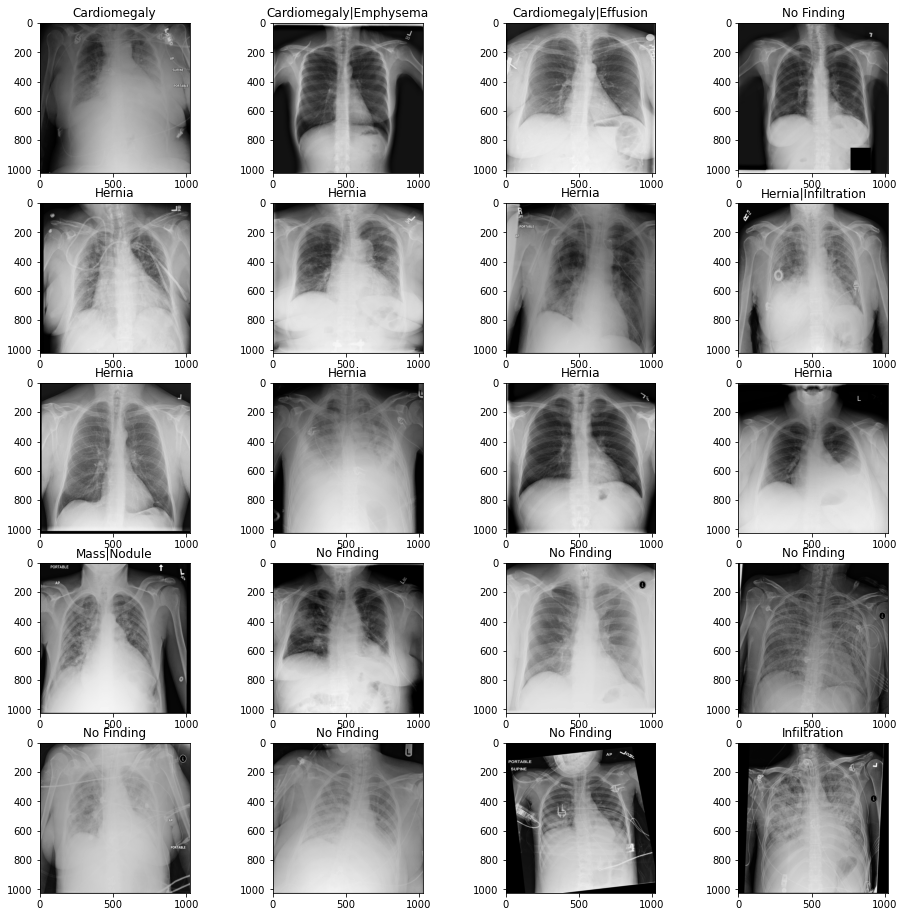

In [6]:
train_data, valid_data = create_splits(all_xray_df)
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_data['Image Index']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(all_image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Finding Labels'])
    ind=ind+1

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
IMG_SIZE = (224, 224)
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0
                           )
    if vargs == 'train':
        return train_idg
    else:
        return val_idg


def make_train_gen(train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
    #                                          directory=None, 
    #                                          x_col = ,
    #                                          y_col = ,
    #                                          class_mode = 'binary',
    #                                          target_size = , 
    #                                          batch_size = 
    #                                          )
    # Todo
    IMG_SIZE = (224, 224)
    train_idg = my_image_augmentation('train')
    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32
                                         )
    return train_gen


def make_val_gen(valid_data):
    
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
    #                                              directory=None, 
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = , 
    #                                              batch_size = ) 

    # Todo
    val_idg = my_image_augmentation('valid')
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_data, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 100)
    return val_gen

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(valid_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


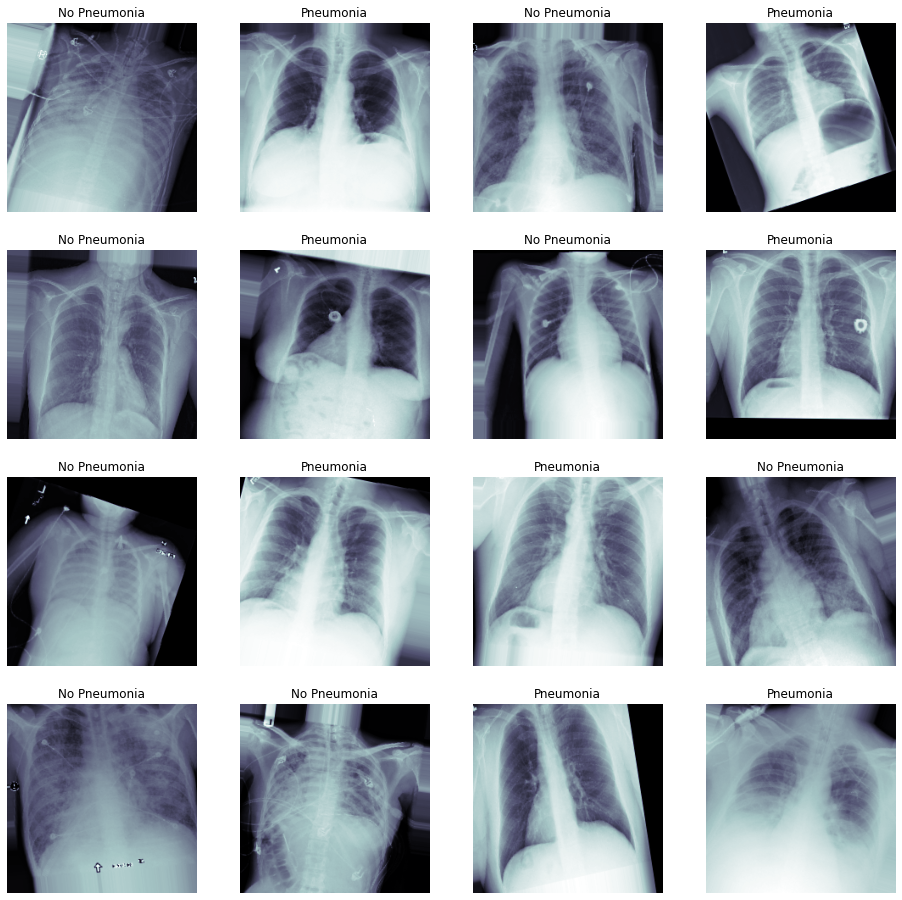

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_train_gen(train_data)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    model.summary()
    return vgg_model

In [11]:
def build_my_model():
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model()
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='relu'))
    '''
    img_dims = 224
    # Input layer
    inputs = Input(shape=(img_dims, img_dims, 3))

    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)

    # Creating model and compiling
    my_model = Model(inputs=inputs, outputs=output)
    '''
    return my_model


my_model =  build_my_model()
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo


optimizer = Adam(lr=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

weight_path="my_model.hdf5"
'''
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'max', 
                      patience=5)

callbacks_list = [checkpoint, early]
'''
my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath=weight_path, save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

### Start training! 

In [24]:
## train your model

# Todo
batch_size = 32
epochs = 20
'''
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10,
                          callbacks = callbacks_list)
'''
history = my_model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=(valX, valY), 
           validation_steps=val_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/20
71/71 [==============================] - 60s 842ms/step - loss: 0.8345 - accuracy: 0.5080 - val_loss: 0.9034 - val_accuracy: 0.5100
Epoch 2/20
71/71 [==============================] - 59s 836ms/step - loss: 0.8094 - accuracy: 0.5031 - val_loss: 0.9573 - val_accuracy: 0.4700
Epoch 3/20
71/71 [==============================] - 59s 828ms/step - loss: 0.7925 - accuracy: 0.5018 - val_loss: 0.9409 - val_accuracy: 0.4500
Epoch 4/20
71/71 [==============================] - 59s 833ms/step - loss: 0.7565 - accuracy: 0.5403 - val_loss: 0.9443 - val_accuracy: 0.4200

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.999999992425728e-07.
Epoch 5/20
71/71 [==============================] - 59s 829ms/step - loss: 0.7842 - accuracy: 0.5199 - val_loss: 0.9983 - val_accuracy: 0.4300
Epoch 6/20
71/71 [==============================] - 59s 833ms/step - loss: 0.7834 - accuracy: 0.5323 - val_loss: 0.9806 - val_accuracy: 0.4400
Epoch 7/20
71/71 [==============================] - 58s 822ms

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 100, verbose = True)
# mapping in range of [0,1]
pred_Y /= 100

100/100 [==============================] - 1s 10ms/step


In [26]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

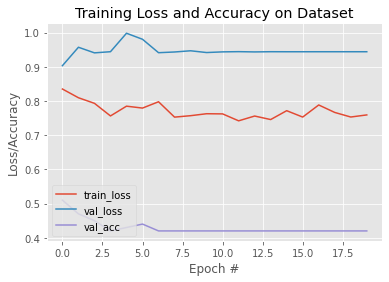

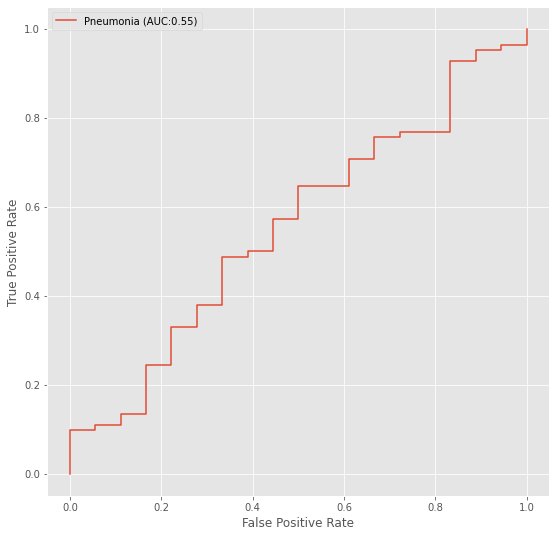

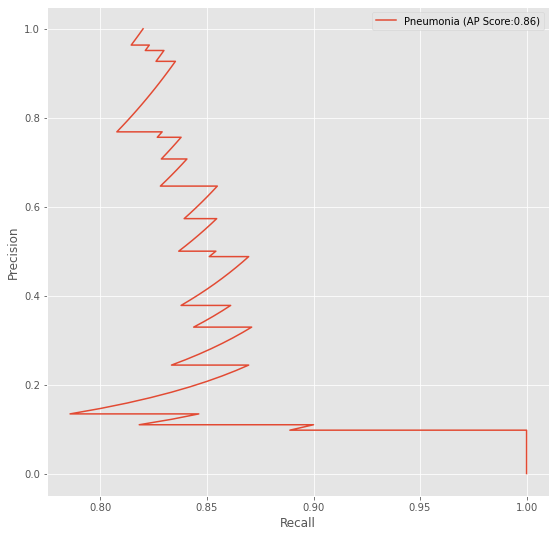

In [27]:
## plot figures

# Todo
plot_history(history)
plot_auc(valY, pred_Y)
plot_pr(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [28]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

precision_value = 0.8
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]

recall_value = 0.5
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]

Precision is: 0.8
Recall is: 0.14634146341463414
Threshold is: 0.006736608
F1 Score is: 0.24742268041237112
Precision is: 0.8367346938775511
Recall is: 0.5
Threshold is: 0.005039066
F1 Score is: 0.6259541984732825


In [29]:
acc = accuracy_score(valY, np.round(pred_Y))*100
cm = confusion_matrix(valY, np.round(pred_Y), labels=[1,0])
tn, fp, fn, tp = cm.ravel()
print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[ 0 82]
 [ 0 18]]

TEST METRICS ----------------------
Accuracy: 18.0%
Precision: 18.0%
Recall: 100.0%
F1-score: 30.508474576271187

TRAIN METRIC ----------------------
Train acc: 50.67


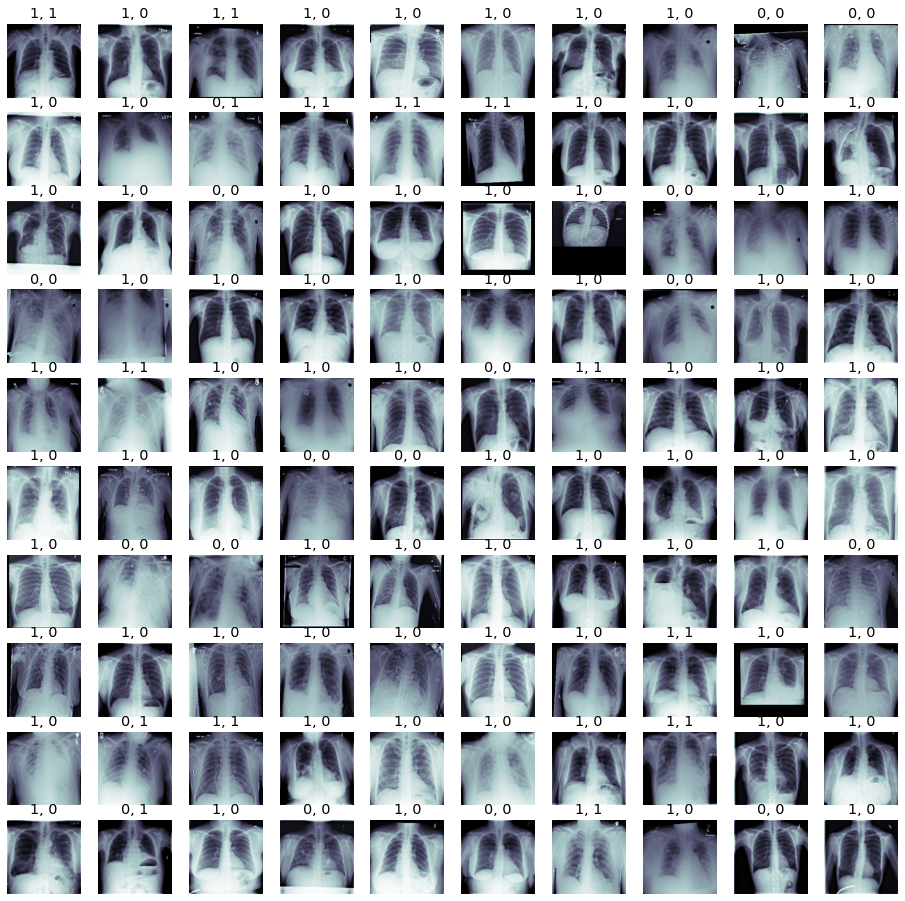

In [30]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds[idx1]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds[idx1]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [31]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)